In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "Arial"

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

from tqdm import tqdm

from config.variables import daynum_dict

from utils.data_processing import (
    remove_users_with_less_than_n_days,
    remove_days_with_less_than_n_kcal,
    longest_continuous_dates,
    process_string,
)

## Loading metadata

In [24]:
fay = pd.read_csv("./data/fay_meta_may24.csv", index_col=0)

## Loading Daywise intake data

In [25]:
df_food_summed = pd.read_csv("./data/daywise_food_summed.csv", index_col=0)

# Replace negative values with zero
numerical_cols = df_food_summed.select_dtypes(include=[np.number]).columns
df_food_summed[numerical_cols] = df_food_summed[numerical_cols].map(lambda x: max(x, 0))

In [26]:
### Filter out the subjects that are not in the fay dataset

df_food_summed = df_food_summed[
    df_food_summed["subject_key"].isin(fay["subject_app_key"].unique())
]

## Assigning season type

In [27]:
def season_assigner(num):
    if num in [11, 12, 1, 2, 3, 4]:
        return "cold"
    else:
        return "warm"


fay["start_month"] = pd.to_datetime(fay["start_date"]).map(lambda x: x.month)
fay["season_type"] = (
    pd.to_datetime(fay["start_date"]).map(lambda x: x.month).map(season_assigner)
)

### Data Preprocessing: 
1. Filtering out the days with less than 1000 kcal 
2. Filtering out the users with less than 7 days of data
3. Filtering out the days that are not part of the longest continuous streak of days

In [28]:
print(df_food_summed.shape)

df_food_summed = remove_days_with_less_than_n_kcal(df_food_summed, kcal_threshold=1000)
print(df_food_summed.shape)

df_food_summed = remove_users_with_less_than_n_days(df_food_summed, 7)
print(df_food_summed.shape)

(21417, 54)
(19216, 54)
(19153, 54)


In [29]:
df_food_filtered = df_food_summed.copy()

for user in tqdm(df_food_summed["subject_key"].unique()):
    dates = sorted(
        df_food_summed[df_food_summed["subject_key"] == user]["eaten_day"].unique()
    )
    longest_streak = longest_continuous_dates(dates)

    df_food_filtered = df_food_filtered[
        ~(
            (df_food_filtered["subject_key"] == user)
            & (~df_food_filtered["eaten_day"].isin(longest_streak))
        )
    ]

100%|██████████| 1002/1002 [00:03<00:00, 298.89it/s]


In [30]:
print(df_food_filtered["subject_key"].nunique())

## Remove users with less than 7 days of data
df_food_filtered = remove_users_with_less_than_n_days(df_food_filtered, 7)

## Adding day of week column
df_food_filtered["day_of_week"] = pd.to_datetime(df_food_filtered["eaten_day"]).map(
    lambda x: x.dayofweek
)
print(df_food_filtered["subject_key"].nunique())

1002
958


In [31]:
df_food_filtered.columns

Index(['subject_key', 'eaten_day', 'eaten_quantity_in_gram',
       'energy_kcal_eaten', 'energy_kj_eaten', 'carb_eaten', 'fat_eaten',
       'protein_eaten', 'fiber_eaten', 'alcohol_eaten', 'beta_carotene_eaten',
       'calcium_eaten', 'cholesterol_eaten',
       'fatty_acids_monounsaturated_eaten',
       'fatty_acids_polyunsaturated_eaten', 'fatty_acids_saturated_eaten',
       'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten',
       'pantothenic_acid_eaten', 'phosphorus_eaten', 'potassium_eaten',
       'salt_eaten', 'sodium_eaten', 'sugar_eaten', 'vitamin_b1_eaten',
       'vitamin_b12_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten',
       'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten',
       'dairy_products_meat_fish_eggs_tofu', 'vegetables_fruits',
       'sweets_salty_snacks_alcohol', 'non_alcoholic_beverages',
       'grains_potatoes_pulses', 'oils_fats_nuts', 'meat_fg_eaten',
       'fruits_fg_eaten', 'vegetables_fg_eaten', 'dairy_fg_eaten',
       'sugar

## Aggregating the data by day of week

In [32]:
df_food_filtered_agg = (
    df_food_filtered.groupby(["subject_key", "day_of_week"])
    .mean(numeric_only=True)
    .reset_index()
)

In [33]:
df_food_filtered_agg.to_csv("./data/df_food_filtered_agg.csv", index=False)

## Visualizing Food Consumption Patterns Using Z-Scores
# 
#### 1. Food Consumption Across Days of the Week
#### 2. Food Consumption Across Months

Text(-0.1, 1.05, 'A')

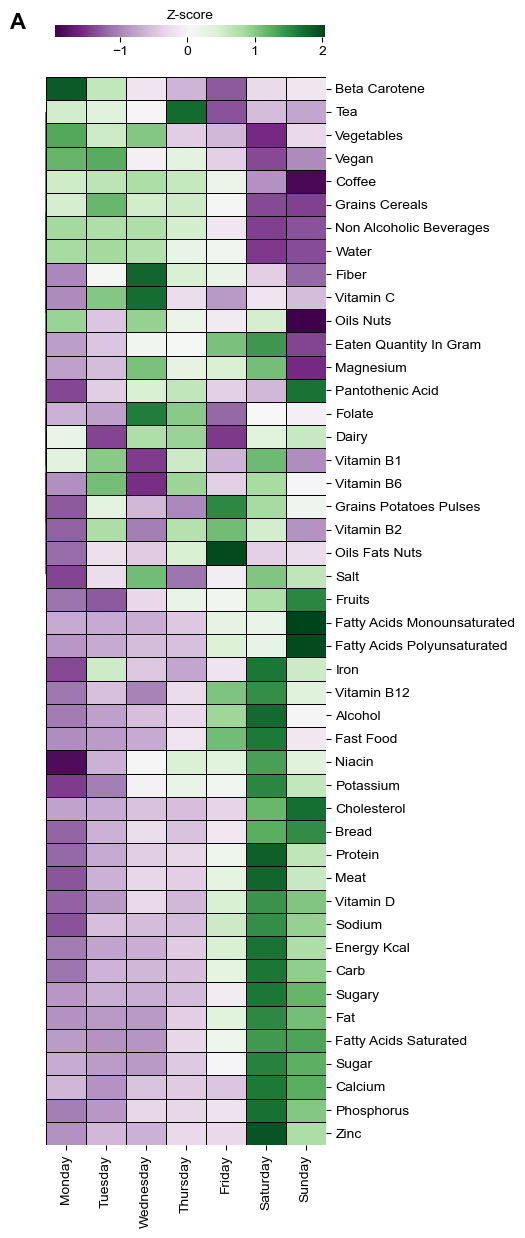

In [34]:
cols_to_remove = [
    "subject_key",
    "alcohol_fg_eaten",
    "others_fg_eaten",
    "energy_kj_eaten",
    "vegetables_fruits",
    "sweets_salty_snacks_alcohol",
    "dairy_products_meat_fish_eggs_tofu",
]

plot_df_food_filtered_mean = (
    df_food_filtered_agg.drop(columns=cols_to_remove).groupby("day_of_week").mean()
)
plot_df_food_filtered_mean.index = plot_df_food_filtered_mean.index.map(
    lambda x: daynum_dict[x]
)
plot_df_food_filtered_mean.columns = map(
    lambda x: process_string(x, newLineSep=6), plot_df_food_filtered_mean.columns
)

################# HORIZONTAL
# g = sns.clustermap(plot_df_food_filtered_mean, linewidths=0.5, linecolor='black',
#                 cmap='PuOr', figsize=(14, 5), row_cluster=False, annot=False, fmt=".2f", z_score=1,
#                 cbar_pos=(0.95, 0.5, 0.012, 0.35), cbar_kws={'label': 'Z-score'},
#                 )
# g.ax_heatmap.set_ylabel("")
# g.ax_heatmap.yaxis.set_ticks_position('left')
################# VERTICAL
g = sns.clustermap(
    plot_df_food_filtered_mean.T,
    linewidths=0.5,
    linecolor="black",
    cmap="PRGn",
    figsize=(5, 12),
    row_cluster=True,
    col_cluster=False,
    annot=False,
    fmt=".2f",
    z_score=0,
    cbar_kws={"label": "Z-score", "orientation": "horizontal"},
    # standard_scale=0, cbar_kws={'label': 'Standardized mean', 'orientation': 'horizontal',},
    dendrogram_ratio=(0.001, 0.001),
    cbar_pos=(0.05, 1.02, 0.54, 0.01),
)
g.ax_heatmap.set_xlabel("")
# g.ax_heatmap.yaxis.set_ticks_position('left')

cbar = g.ax_heatmap.collections[0].colorbar
# cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position("top")

#################

## Add a text at top left corner
g.ax_heatmap.text(
    -0.1,
    1.05,
    "A",
    fontsize=16,
    ha="center",
    va="center",
    fontweight="bold",
    transform=g.ax_heatmap.transAxes,
)

Text(-0.1, 1.045, 'B')

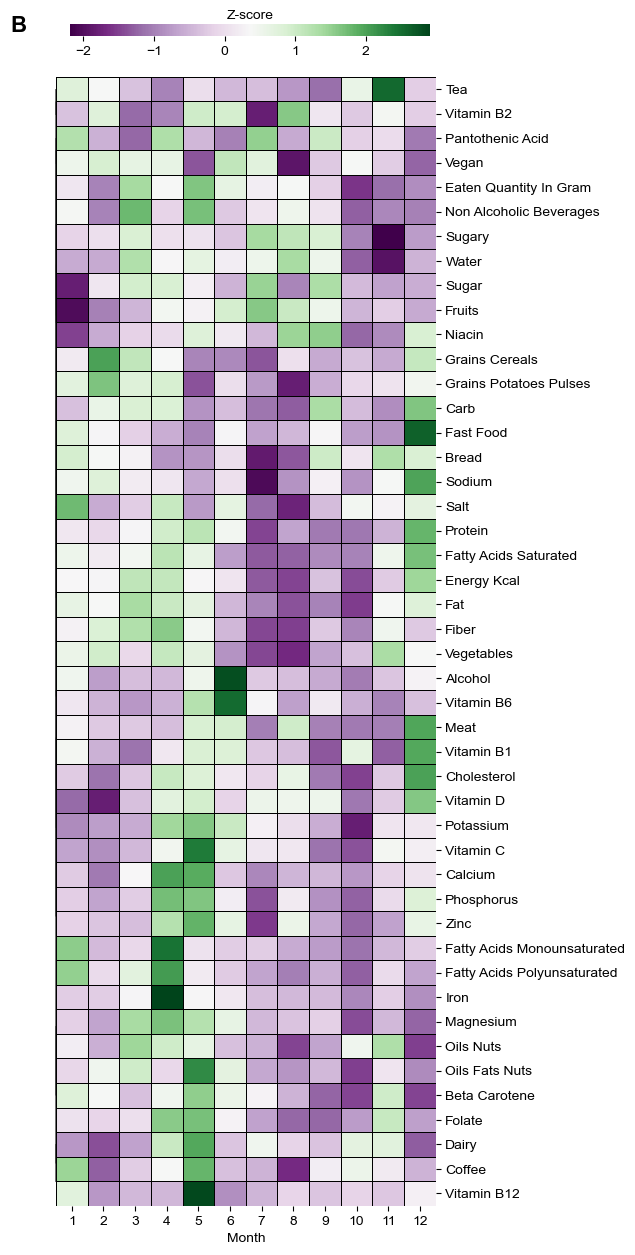

In [35]:
cols_to_remove = [
    "subject_key",
    "alcohol_fg_eaten",
    "others_fg_eaten",
    "energy_kj_eaten",
    "vegetables_fruits",
    "sweets_salty_snacks_alcohol",
    "dairy_products_meat_fish_eggs_tofu",
]

df_food_month = df_food_filtered_agg.merge(
    fay[["subject_app_key", "start_month"]],
    left_on="subject_key",
    right_on="subject_app_key",
)
plot_df_food_filtered_mean = (
    df_food_month.drop(columns=cols_to_remove + ["day_of_week", "subject_app_key"])
    .groupby("start_month")
    .mean()
)
# plot_df_food_filtered_mean.index = plot_df_food_filtered_mean.index.map(lambda x: daynum_dict[x])
plot_df_food_filtered_mean.columns = map(
    lambda x: process_string(x, newLineSep=6), plot_df_food_filtered_mean.columns
)
plot_df_food_filtered_mean = plot_df_food_filtered_mean[
    sorted(plot_df_food_filtered_mean.columns)
]

###############
# g = sns.clustermap(plot_df_food_filtered_mean, linewidths=0.5, linecolor='black',
#                 cmap='PuOr', figsize=(14, 5), row_cluster=False,  col_cluster=False,
#                 annot=False, fmt=".2f", standard_scale=1, #z_score=1, #standard_scale=1,
#                 cbar_pos=(0.99, 0.5, 0.012, 0.35), cbar_kws={'label': 'Z-score'},
#                 )
# g.ax_heatmap.set_ylabel("")
# g.ax_heatmap.yaxis.set_ticks_position('left')
###############
g = sns.clustermap(
    plot_df_food_filtered_mean.T,
    linewidths=0.5,
    linecolor="black",
    cmap="PRGn",
    figsize=(6, 12),
    row_cluster=True,
    col_cluster=False,
    annot=False,
    fmt=".2f",
    z_score=0,
    cbar_kws={"label": "Z-score", "orientation": "horizontal"},
    # #standard_scale=0,  cbar_kws={'label': 'Standardized mean', 'orientation': 'horizontal'},
    dendrogram_ratio=(0.001, 0.001),
    cbar_pos=(0.05, 1.02, 0.6, 0.01),
)
g.ax_heatmap.set_xlabel("Month")
# g.ax_heatmap.yaxis.set_ticks_position('left')

cbar = g.ax_heatmap.collections[0].colorbar
# cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position("top")

## Add a text at top left corner
g.ax_heatmap.text(
    -0.1,
    1.045,
    "B",
    fontsize=16,
    ha="center",
    va="center",
    fontweight="bold",
    transform=g.ax_heatmap.transAxes,
)